In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import linear_model
import urllib, json
import re
from itertools import permutations
from pulp import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [3]:
nbaStats = pd.read_csv('C:/Users/jschlajo/Downloads/playoff.csv')
salaries = pd.read_csv('C:/Users/jschlajo/Downloads/satNames.csv')

In [4]:
potentialFeatures = set(list(nbaStats.columns)) - set(list(['Index','NBA_FANTASY_PTS']))

In [34]:
nbaStats.head()

,Unnamed: 0,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK
0,0,2018-19,1626181,Norman Powell,1610612761,TOR,Toronto Raptors,41800302,2019-05-17T00:00:00,TOR @ MIL,...,631,446,1,1219,1052,405,1011,664,130,11
1,1,2018-19,1628391,D.J. Wilson,1610612749,MIL,Milwaukee Bucks,41800302,2019-05-17T00:00:00,MIL vs. TOR,...,631,446,1043,313,729,1142,641,1280,130,11
2,2,2018-19,1626259,Malcolm Miller,1610612761,TOR,Toronto Raptors,41800302,2019-05-17T00:00:00,TOR @ MIL,...,631,446,1,313,729,1142,852,1280,130,11
3,3,2018-19,202703,Nikola Mirotic,1610612749,MIL,Milwaukee Bucks,41800302,2019-05-17T00:00:00,MIL vs. TOR,...,631,446,1,1219,317,356,581,601,130,11
4,4,2018-19,1627783,Pascal Siakam,1610612761,TOR,Toronto Raptors,41800302,2019-05-17T00:00:00,TOR @ MIL,...,236,446,1,1491,1052,710,1446,829,130,11


In [5]:
# ordinary least squares regression to find correlation between a column and total fantasy points
rSquared = []
for x in potentialFeatures:
    
    X = nbaStats[x]
    y = nbaStats["NBA_FANTASY_PTS"]

    try:
        # Note the difference in argument order
        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model
        
        r2  = model.rsquared
        coef = model.params.item()
        value = (x, r2, coef)
        rSquared.append(value)

    except:
        # variable cannot be converted to a numpy dtype
        continue

In [6]:
r2DataFrame = pd.DataFrame(rSquared)
r2DataFrame.columns = ['Feature','r^2','coef']

In [7]:
r2DataFrame[r2DataFrame['r^2'] >.5].head()

,Feature,r^2,coef
4,FTA,0.641463,5.434104
5,DREB,0.773947,5.255210
6,AST,0.698975,6.662183
8,MIN,0.877016,0.932556
12,FG_PCT,0.630448,43.390908


In [8]:
# use features with r^2 > 50 in regression model
features = r2DataFrame[r2DataFrame['r^2'] >.5]['Feature'].tolist()

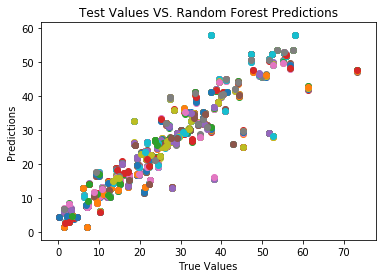

In [9]:
regerssion = []
randomForest = []

nextGamePred = []
data = []

tonight = []

errorDict = collections.defaultdict(dict)

for index, x in enumerate(nbaStats['PLAYER_NAME'].tolist()):
        
        playerDf = nbaStats[nbaStats['PLAYER_NAME'] == x]

        playerDf['roll1'] = pd.Series(playerDf['NBA_FANTASY_PTS']).rolling(window=1).mean()
        playerDf['roll3'] = pd.Series(playerDf['NBA_FANTASY_PTS']).rolling(window=3).mean()
        playerDf['roll5'] = pd.Series(playerDf['NBA_FANTASY_PTS']).rolling(window=5).mean()
        playerDf['roll10'] = pd.Series(playerDf['NBA_FANTASY_PTS']).rolling(window=10).mean()
        playerDf = playerDf.dropna()
        playerDf = playerDf.reset_index()

        train = playerDf[len(playerDf) - int(len(playerDf.reset_index())*.80):]
        # train with trailing 95 percent of the data

        test = playerDf[:len(playerDf) - int(len(playerDf.reset_index())*.20)]
        #test on most recent 5%

        X_train = pd.concat([train[features], train[['roll1','roll3','roll5','roll10']]], axis=1)
        X_test = pd.concat([test[features], test[['roll1','roll3','roll5','roll10']]], axis=1)

        y_train = train['NBA_FANTASY_PTS']
        y_test = test['NBA_FANTASY_PTS']
        
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        # Original training method with random shuffle splits


        # create training and testing vars
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80    

        # train_features, test_features, train_labels, test_labels

        # fit a model
        try:
            lm = linear_model.LinearRegression()
            model = lm.fit(X_train, y_train)
            predictions = lm.predict(X_test)


            regErrors = abs(predictions - y_test)
            errorDict[x]['regression'] = round(np.mean(regErrors), 2)
    #         print('Regression Mean Absolute Error:', round(np.mean(regErrors), 2), 'degrees.')


            rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_features='sqrt')
            rf.fit(X_train, y_train)
            RFpredictions = rf.predict(X_test)

            rfErrors = abs(RFpredictions - y_test)
            errorDict[x]['RF'] = round(np.mean(rfErrors), 2)
    #         print('RF Mean Absolute Error:', round(np.mean(rfErrors), 2), 'degrees.')

            errorDict[x]['size'] = len(playerDf)


            avgPlayerPrediction = RFpredictions.mean()
            nextDayPred = predictions[0]
            data.append(predictions)
            # take the average from the list of predictions made by the regression

            ## The line / model
            plt.scatter(y_test,RFpredictions)
            plt.xlabel('True Values')
            plt.ylabel('Predictions')
            plt.title('Test Values VS. Random Forest Predictions')


            errorDict[x]['playerData'] = list(zip(list(y_test), list(RFpredictions)))

            info = (x, avgPlayerPrediction)
            nextGamePred.append(info)

        except ValueError:
            # this player did not play enough games to perform a regression analysis
            continue

In [18]:
playerPreds = pd.DataFrame(nextGamePred)
playerPreds.columns = ['Player','Prediction']
playerPreds = playerPreds.drop_duplicates('Player')
playerPreds.sort_values('Prediction', ascending=False).head(10)

,Player,Prediction
92,Joel Embiid,58.0000
110,James Harden,53.6000
16,Giannis Antetokounmpo,52.4000
68,Nikola Jokic,49.7494
18,Damian Lillard,47.2797
5,Kawhi Leonard,44.8399
30,CJ McCollum,42.0220
77,Ben Simmons,41.9617
155,Kevin Durant,41.3000
97,Jimmy Butler,40.5985


In [19]:
salaries = pd.read_csv('C:/Users/jschlajo/Downloads/satNames.csv')
salaries = salaries[['Position','Nickname','Salary','Team']]

In [20]:
salaries.head()

,Position,Nickname,Salary,Team
0,SF,Giannis Antetokounmpo,12000,MIL
1,SF,Kevin Durant,11000,GS
2,SF,Kawhi Leonard,10500,TOR
3,PG,Stephen Curry,10300,GS
4,PG,Damian Lillard,9400,POR


In [21]:
# import fandual salary and position data for team optimization
fandualOptions = playerPreds.merge(salaries, left_on='Player', right_on='Nickname', how='inner')
fandualOptions = fandualOptions[['Player','Prediction','Position','Salary']]
fandualOptions.columns = ['displayName','points','position','salary']

In [25]:
badList = ['Jusuf Nurkic','DeMarcus Cousins','Pau Gasol', 'Kevin Durant']

In [26]:
fandualOptions = fandualOptions[fandualOptions['displayName'].isin(badList)==False]

In [27]:
fandualOptions.head()

,displayName,points,position,salary
0,Norman Powell,13.197925,SF,3500
1,Nikola Mirotic,1.500000,SF,5200
2,Pascal Siakam,37.144025,PF,7300
3,Ersan Ilyasova,15.200000,PF,4200
4,Brook Lopez,32.600000,C,5800


In [28]:
salaries = {}
points = {}

for pos in fandualOptions.position.unique():
    available_pos = fandualOptions[fandualOptions.position == pos]
    salary = list(available_pos[["displayName","salary"]].set_index("displayName").to_dict().values())[0]
    point = list(available_pos[["displayName","points"]].set_index("displayName").to_dict().values())[0]
    salaries[pos] = salary
    points[pos] = point
    
    
pos_num_available = {
    'PG':2,
    'SG':2,
    'SF':2,
    'PF':2,
    'C':1
}


SALARY_CAP = 60000

In [29]:
_vars = {k: LpVariable.dict(k, v, cat="Binary") for k, v in points.items()}

In [30]:
prob = LpProblem("Fantasy", LpMaximize)
rewards = []
costs = []
position_constraints = []
# Setting up the reward
for k, v in _vars.items():
    costs += lpSum([salaries[k][i] * _vars[k][i] for i in v])
    rewards += lpSum([points[k][i] * _vars[k][i] for i in v])
    prob += lpSum([_vars[k][i] for i in v]) == pos_num_available[k]
    
prob += lpSum(rewards)
prob += lpSum(costs) <= SALARY_CAP

In [31]:
prob.solve()

1

In [32]:
winningTeam = []

def summary(prob):
    div = '---------------------------------------\n'
    print("Variables:\n")
    score = str(prob.objective)
    constraints = [str(const) for const in prob.constraints.values()]
    for v in prob.variables():
        score = score.replace(v.name, str(v.varValue))
        constraints = [const.replace(v.name, str(v.varValue)) for const in constraints]
        if v.varValue != 0:
            print(v.name, "=", v.varValue)
            winningTeam.append(v.name)
    print(div)
    print("Constraints:")
    for constraint in constraints:
        constraint_pretty = " + ".join(re.findall("[0-9\.]*\*1.0", constraint))
        if constraint_pretty != "":
            print("{} = {}".format(constraint_pretty, eval(constraint_pretty)))
    print(div)
    print("Score:")
    score_pretty = " + ".join(re.findall("[0-9\.]+\*1.0", score))
    print("{} = {}".format(score_pretty, eval(score)))

In [33]:
summary(prob)

Variables:

C_Brook_Lopez = 1.0
PF_Al_Farouq_Aminu = 1.0
PF_Pascal_Siakam = 1.0
PG_Eric_Bledsoe = 1.0
PG_Kyle_Lowry = 1.0
SF_Giannis_Antetokounmpo = 1.0
SF_Maurice_Harkless = 1.0
SG_CJ_McCollum = 1.0
SG_Pat_Connaughton = 1.0
---------------------------------------

Constraints:
5800*1.0 + 4000*1.0 + 7300*1.0 + 5400*1.0 + 7500*1.0 + 12000*1.0 + 4900*1.0 + 7900*1.0 + 5000*1.0 = 59800.0
---------------------------------------

Score:
32.599999999999405*1.0 + 26.705749999999643*1.0 + 37.14402500000003*1.0 + 29.099999999999508*1.0 + 35.884749999999976*1.0 + 52.400000000000915*1.0 + 27.758449999999854*1.0 + 42.02200000000002*1.0 + 25.09999999999966*1.0 = 308.7149749999991
